# MAGPRIME Tutorial notebook

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from magprime import ICA, MSSA, NESS, PiCoG, SHEINKER, REAM, UBSS, WAICUP 
import datetime

### Load data from Michibiki-1 Magnetometers

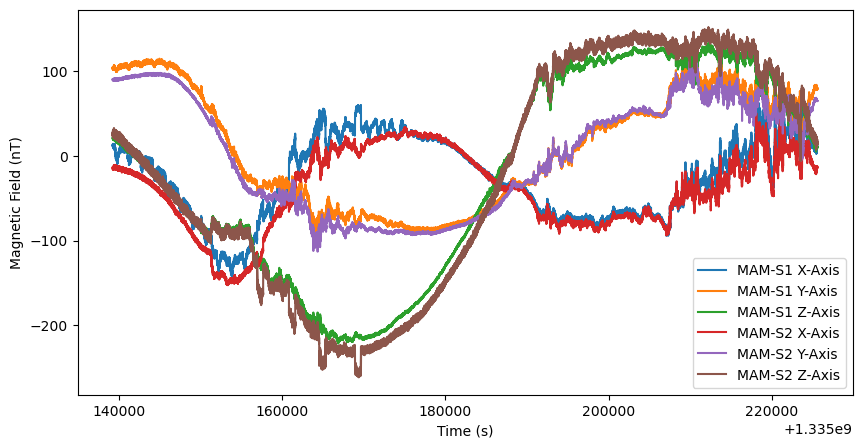

In [19]:
# https://sees.tksc.jaxa.jp/fw/dfw/SEES/English/Papers/data/2020/peer_reviewed/01/2020_reviewed_01.shtml

qzs_1 = np.loadtxt(r"examples\SPACE_DATA\michibiki.dat", dtype=np.float, usecols=(0,4,5,6,7,8,9))
B_qzs = qzs_1.T

# Subtract offsets
B_qzs[1] -= 60 # MAM-S1 X-Axis
B_qzs[2] -= 410 # MAM-S1 Y-Axis
B_qzs[3] -= -202 # MAM-S1 Z-Axis
B_qzs[4] -= -528 # MAM-S2 X-Axis
B_qzs[5] -= -200 # MAM-S2 Y-Axis
B_qzs[6] -= 478 # MAM-S2 Z-Axis

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(B_qzs[0], B_qzs[1], label="MAM-S1 X-Axis")
plt.plot(B_qzs[0], B_qzs[2], label="MAM-S1 Y-Axis")
plt.plot(B_qzs[0], B_qzs[3], label="MAM-S1 Z-Axis")
plt.plot(B_qzs[0], B_qzs[4], label="MAM-S2 X-Axis")
plt.plot(B_qzs[0], B_qzs[5], label="MAM-S2 Y-Axis")
plt.plot(B_qzs[0], B_qzs[6], label="MAM-S2 Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.show()


In [18]:
# Rearrange B into (n_sensors, n_axes, n_samples)
B1 = np.vstack((B_qzs[1], B_qzs[2], B_qzs[3]))
B2 = np.vstack((B_qzs[4], B_qzs[5], B_qzs[6]))
B = np.stack((B1, B2))
print(B.shape)

(2, 3, 86400)
